In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [12]:
periods = 10
ppp=10000


import os 
os.system("python3 main_traj.py --periods {} --ppp {}".format(periods, ppp))

0

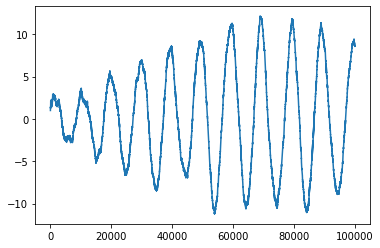

In [13]:
from misc import load_data, get_def_path

train_id = 0
defpath = get_def_path()
path = defpath+"{}periods/{}ppp/".format(periods,ppp)
means, covs, signals, coeffs = load_data(path)
tfsignals = tf.convert_to_tensor(signals)[tf.newaxis]
A,dt,C,D = coeffs
times = np.linspace(0,periods, periods*ppp+1)
total_time = times[-1]
plt.plot(means[:,0])

In [14]:
from visual_model import *

In [15]:
rmodel = GRNNmodelVisual(coeffs = [C,D,dt, total_time], traj_details=[periods, ppp, train_id, path], cov_in=tf.convert_to_tensor(covs[0].astype(np.float32)), stateful=False)
rmodel.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01))
rmodel.recurrent_layer(tfsignals[:,:10,:], initial_state=rmodel.initial_state)
#rmodel.trainable_variables[0].assign(tf.convert_to_tensor(A.astype(np.float32)))

<tf.Tensor: shape=(1, 10, 2), dtype=float32, numpy=
array([[[ 1.9999999e-04,  0.0000000e+00],
        [ 2.1744816e-04, -6.5709933e-06],
        [ 2.1178009e-04, -1.8085402e-05],
        [ 2.2105851e-04, -3.8085400e-05],
        [ 2.3974775e-04, -4.6244040e-05],
        [ 2.4316189e-04, -4.8917838e-05],
        [ 2.5879353e-04, -6.8917841e-05],
        [ 2.5534973e-04, -7.3027659e-05],
        [ 2.6744828e-04, -8.4772590e-05],
        [ 2.6560991e-04, -9.4139548e-05]]], dtype=float32)>

In [16]:
parameters = np.arange(0,4*np.pi+np.pi/2,np.pi/2)

loss_values = {}

for length_series in [int(len(signals)), int(len(signals)/2), int(len(signals)/10)]:
    
    l={}
    for th in tqdm(parameters):
        rmodel.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[th]]).astype(np.float32)))
        dy = tfsignals[:,:length_series,:]
        tr = rmodel(dy)
        diff = (tr - dy)[0]
        l[th] = np.sum(tf.einsum('bj,bj->b',diff,diff))/2
    loss_values[length_series] = np.array(list(l.values()))


100%|██████████| 9/9 [02:18<00:00, 15.34s/it]


Text(0.5, 1.0, '$\\omega = $6.28')

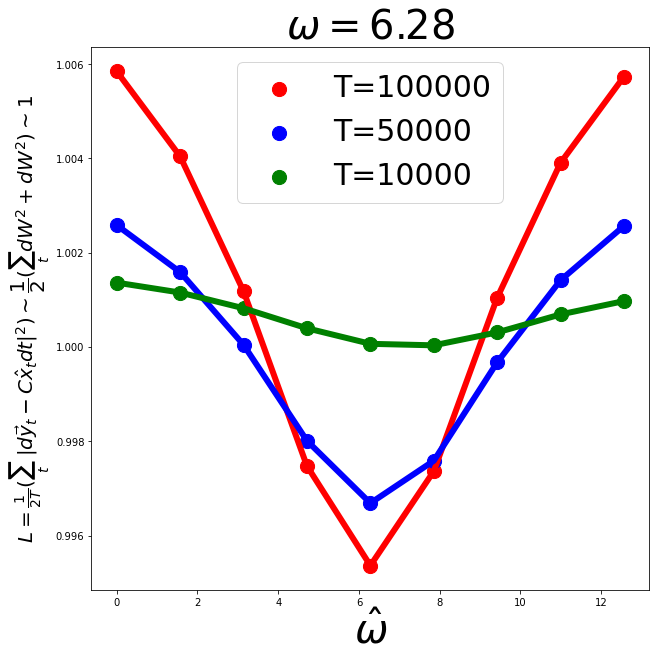

In [17]:
plt.figure(figsize=(10,10))
for ind,length_series in enumerate(list(loss_values.keys())):
    plt.plot(parameters,loss_values[length_series]/(dt*length_series), color=["red","blue","green"][ind], linewidth=6)
    plt.scatter(parameters,loss_values[length_series]/(dt*length_series), label="T=" + str(length_series), color=["red","blue","green"][ind], s=200)
    
plt.xlabel(r'$\hat{\omega}$', size=40)
plt.ylabel(r'$L = \frac{1}{2 T}(\sum_t \; |d\vec{y}_t - C\hat{x}_t dt|^2) \sim \dfrac{1}{2} (\sum_t dW^2 + dW^2) \sim 1$',size=20)
plt.legend(prop={'size':30})
plt.title(r'$\omega = $'+str(np.round(2*np.pi,2)),size=40)
#plt.xticks(ticks=parameters, labels=[np.round(k,2) for k in parameters])

In [8]:
for k,v in loss_values.items():
    os.makedirs(get_def_path()+"loss_landscape/",exist_ok=True)
    np.save(get_def_path()+"loss_landscape/{}_{}".format(periods,ppp)+str(k),v)